In [1]:
# SETUP & IMPORTS

import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

print(torch.__version__)


1.13.1+cu116


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# DEFINE & CREATE DATASET

class CreditcardDataset(Dataset):

    def __init__(self, csv_file, type_dataset, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.type_dataset = type_dataset

        self.df = pd.read_csv(csv_file, sep=",")
        
        self.df = self.df.drop('Time', axis=1)
        
        if (self.type_dataset >=0):
            self.df = self.df[self.df.Class == type_dataset]

        y = self.df.iloc[:]['Class'].values
        x = self.df.drop('Class', axis=1).values
        
        self.X = torch.tensor(x, dtype=torch.float32)
        self.Y = torch.tensor(y)
        
        self.transform = transform
        
        print ('type_dataset=', self.type_dataset)
        print(self.df.iloc[:]['Class'].value_counts())

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] #sample
    

path = "/content/drive/MyDrive/data/creditcard.csv"
#ENTIRE_dataset    = CreditcardDataset(csv_file='./data/creditcard.csv', type_dataset=-1)
NORMAL_dataset    = CreditcardDataset(csv_file=path, type_dataset=0)
ANOMALIES_dataset = CreditcardDataset(csv_file=path, type_dataset=1)

"""
0    284315
1       492
Name: Class, dtype: int64
"""

type_dataset= 0
0    284315
Name: Class, dtype: int64
type_dataset= 1
1    492
Name: Class, dtype: int64


'\n0    284315\n1       492\nName: Class, dtype: int64\n'

In [4]:
# PREPARE DATASETS & LOADERS

# NORMAL Dataset
# Use ONLY NORMAL transactions to train the Autoencoder

batch_size = 128
train_split = 0.9 # 90%
val_split = 0.98 #0.5 # xx% del resto

train_size = int(train_split * len(NORMAL_dataset))
val_size = int(val_split * (len(NORMAL_dataset) - train_size))
test_size = len(NORMAL_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(NORMAL_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                            shuffle=True, 
                            num_workers=0,
                            #sampler=train_sampler
                            )
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=True, 
                            num_workers=0,
                            #sampler=val_sampler
                            )
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=True, 
                            num_workers=0,
                            #sampler=test_sampler
                            )

print ("# total samples NORMAL:", len(NORMAL_dataset))
print ("# total TRAIN samples NORMAL:", len(train_loader.sampler))
print ("# total VAL samples NORMAL:", len(val_loader.sampler))
print ("# total TEST samples NORMAL:", len(test_loader.sampler))

# Show on iteration from train dataset
# iter() calls the __iter__() method on the loader which returns an iterator.
# next() then calls the __next__() method on that iterator to get the first iteration.
# Running next() again will get the second item of the iterator, etc.

dataiter = iter(train_loader)

"""
X, Y = next(dataiter)
print ('data from one iteration:', X)
print ('labels from one iteration:', Y)
"""

# ANOMALIES Dataset
# Use ANOMALIES transactions to test the Autoencoder

ANOMALIES_test_loader = DataLoader(ANOMALIES_dataset, batch_size=batch_size,
                            shuffle=True, 
                            num_workers=0,
                            #sampler=test_sampler
                            )

print ("# total samples ANOMALIES:", len(ANOMALIES_dataset))
print ("# total TEST samples ANOMALIES:", len(ANOMALIES_test_loader.sampler))


# total samples NORMAL: 284315
# total TRAIN samples NORMAL: 255883
# total VAL samples NORMAL: 27863
# total TEST samples NORMAL: 569
# total samples ANOMALIES: 492
# total TEST samples ANOMALIES: 492


In [5]:
# ACTIVATE DEVICE

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)


cuda:0


'Tesla T4'

In [6]:
# DEFINE NEURAL NETWORK MODEL
# AUTOENCODER = ENCODER + DECODER

class encoderNet(nn.Module):

    def __init__(self):

        super(encoderNet, self).__init__()

        # specify layer 1 - in 29, out 14
        self.encoder_L1 = nn.Linear(in_features=29, out_features=14, bias=True) 
        nn.init.xavier_uniform_(self.encoder_L1.weight) 
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) 

        # specify layer 2 - in 14, out 7
        self.encoder_L2 = nn.Linear(14, 7, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 7, out 4
        self.encoder_L3 = nn.Linear(7, 4, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.dropout(self.encoder_L1(x)))
        x = self.encoder_R2(self.dropout(self.encoder_L2(x)))
        x = self.encoder_R3(self.encoder_L3(x)) 

        return x


class decoderNet(nn.Module):

    def __init__(self):

        super(decoderNet, self).__init__()

        # specify layer 1 - in 4, out 7
        self.decoder_L1 = nn.Linear(in_features=4, out_features=7, bias=True)  
        nn.init.xavier_uniform_(self.decoder_L1.weight)  
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) 

        # specify layer 2 - in 7, out 14
        self.decoder_L2 = nn.Linear(7, 14, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 14, out 29
        self.decoder_L3 = nn.Linear(14, 29, bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.dropout(self.decoder_L1(x)))
        x = self.decoder_R2(self.dropout(self.decoder_L2(x)))
        x = self.decoder_R3(self.decoder_L3(x))
        
        return x

encoder = encoderNet()
decoder = decoderNet()

encoder.to(device)
decoder.to(device)

print (encoder)
print (decoder)


encoderNet(
  (encoder_L1): Linear(in_features=29, out_features=14, bias=True)
  (encoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L2): Linear(in_features=14, out_features=7, bias=True)
  (encoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L3): Linear(in_features=7, out_features=4, bias=True)
  (encoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (dropout): Dropout(p=0.0, inplace=True)
)
decoderNet(
  (decoder_L1): Linear(in_features=4, out_features=7, bias=True)
  (decoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L2): Linear(in_features=7, out_features=14, bias=True)
  (decoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L3): Linear(in_features=14, out_features=29, bias=True)
  (decoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (dropout): Dropout(p=0.0, inplace=True)
)


In [7]:
# DEFINE LOSS FUNCTION AND OPTIMIZATION METHOD

#criterion = nn.L1Loss(reduction='mean')
criterion = nn.MSELoss(reduction='mean')

learning_rate = 1e-3
encoder_optimizer = torch.optim.Adam(encoder.parameters(), learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), learning_rate)

In [8]:
# DEFINE TRAIN & EVAL FUNCTIONS

def train_model(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, epoch):
  
    encoder.train()
    decoder.train()

    total_epoch_loss = 0
      
    for i, (X, Y) in enumerate(train_loader):
        # X from dataset: [batch, 29]
        # Y from dataset: [batch]
        
        X = X.to(device)
        
        # Forward pass
        Z = encoder(X)
        output = decoder(Z)

        reconstruction_loss = criterion(output, X)
        
        # Backward and optimize
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

        reconstruction_loss.backward()
        
        #Update parameters for our model
        decoder_optimizer.step()
        encoder_optimizer.step()

        if (i+1) % 1000 == 0:
          print (f'Epoch: {epoch+1}, Idx: ({i+1}/{len(train_loader)}), Training Loss: {reconstruction_loss.item():.4f}')
      
        total_epoch_loss += reconstruction_loss.item()

    return total_epoch_loss/len(train_loader)


def eval_model(encoder, decoder, val_loader, criterion):

  encoder.eval()
  decoder.eval()

  total_epoch_loss = 0

  with torch.no_grad():
        
    for i, (X, Y) in enumerate(val_loader):
        # X from dataset: [batch, 29]
        # Y from dataset: [batch]
        
        X = X.to(device)
        
        # Forward pass
        Z = encoder(X)
        output = decoder(Z)

        reconstruction_loss = criterion(output, X)
       
        total_epoch_loss += reconstruction_loss.item()
       
    return total_epoch_loss/len(val_loader)


Epoch: 1, Idx: (100/2000), Training Loss: 137.7106
Epoch: 1, Idx: (200/2000), Training Loss: 1.4701
Epoch: 1, Idx: (300/2000), Training Loss: 1.3079
Epoch: 1, Idx: (400/2000), Training Loss: 2.2124
Epoch: 1, Idx: (500/2000), Training Loss: 0.8840
Epoch: 1, Idx: (600/2000), Training Loss: 1.1684
Epoch: 1, Idx: (700/2000), Training Loss: 1.2295
Epoch: 1, Idx: (800/2000), Training Loss: 1.0197
Epoch: 1, Idx: (900/2000), Training Loss: 1.0523
Epoch: 1, Idx: (1000/2000), Training Loss: 0.7362
Epoch: 1, Idx: (1100/2000), Training Loss: 2.7016
Epoch: 1, Idx: (1200/2000), Training Loss: 1.0455
Epoch: 1, Idx: (1300/2000), Training Loss: 0.8295
Epoch: 1, Idx: (1400/2000), Training Loss: 2.3636
Epoch: 1, Idx: (1500/2000), Training Loss: 1.1817
Epoch: 1, Idx: (1600/2000), Training Loss: 9.9721
Epoch: 1, Idx: (1700/2000), Training Loss: 0.8474
Epoch: 1, Idx: (1800/2000), Training Loss: 1.0542
Epoch: 1, Idx: (1900/2000), Training Loss: 0.8696
Epoch: 1, Idx: (2000/2000), Training Loss: 0.4766
Epoch: 

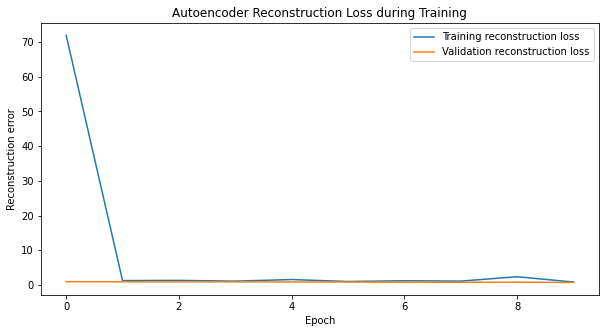

In [10]:
# TRAINING LOOP

since = time.time()

epochs = 10 
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(epochs):
    train_loss = train_model(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, epoch)
    val_loss   = eval_model(encoder, decoder, val_loader, criterion)
    
    print(f'Epoch: [{epoch+1:02}/{epochs}], Train Loss: {train_loss:.3f}, Val. Loss: {val_loss:3f}')
    train_loss_epochs.append(train_loss)
    val_loss_epochs.append(val_loss)

    
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

plt.figure(figsize=(10,5))
plt.title("Autoencoder Reconstruction Loss during Training")
plt.plot(train_loss_epochs,label="Training reconstruction loss")
plt.plot(val_loss_epochs,label="Validation reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction error")
plt.legend()
plt.show()

#torch.save(encoder.state_dict(), './models/encoderAnomaliesNET.pth')
#torch.save(decoder.state_dict(), './models/decoderAnomaliesNET.pth')

In [11]:
# TEST THE MODEL

total_epoch_loss = 0

with torch.no_grad():
    for X, Y in test_loader:
     
        X = X.to(device)

        output = decoder(encoder(X))

        reconstruction_loss = criterion(output, X)
        #print (reconstruction_loss)
       
        total_epoch_loss += reconstruction_loss.item()

    print ('Reconstruction Loss TEST_NORMAL: ', total_epoch_loss/len(test_loader))

total_epoch_loss = 0

with torch.no_grad():
    for X, Y in ANOMALIES_test_loader:
     
        X = X.to(device)

        output = decoder(encoder(X))

        reconstruction_loss = criterion(output, X)
        #print (reconstruction_loss)
       
        total_epoch_loss += reconstruction_loss.item()

    print ('Reconstruction Loss TEST_ANOMALIES: ', total_epoch_loss/len(ANOMALIES_test_loader))

Reconstruction Loss TEST_NORMAL:  0.7650341987609863
Reconstruction Loss TEST_ANOMALIES:  26.607819080352783


In [12]:
# CALCULATE THE RECONSTRUCTION LOSS FOR TEST & ANOMALIES DATASET

reconstruction_loss_all = []

with torch.no_grad():
    #for i in range(len(NORMAL_dataset)):
    for i in range(len(test_dataset)):
     
        #X = NORMAL_dataset[i][0]
        X = test_dataset[i][0]
        X = X.to(device)

        output = decoder(encoder(X))

        reconstruction_loss = criterion(output, X)
        #print (reconstruction_loss)
       
        reconstruction_loss_all.append(reconstruction_loss.item())

#print ('Reconstruction Loss ALL (NORMAL): ', len (reconstruction_loss_all))
print ('Reconstruction Loss test (NORMAL): ', len (reconstruction_loss_all))

with torch.no_grad():
    for i in range(len(ANOMALIES_dataset)):
     
        X = ANOMALIES_dataset[i][0]
        X = X.to(device)

        output = decoder(encoder(X))

        reconstruction_loss = criterion(output, X)
        #print (reconstruction_loss)
       
        reconstruction_loss_all.append(reconstruction_loss.item())

    print ('Reconstruction Loss ALL (ANOMALIES): ', len (reconstruction_loss_all))



Reconstruction Loss test (NORMAL):  569
Reconstruction Loss ALL (ANOMALIES):  1061


Text(0.5, 0, 'Data point index')

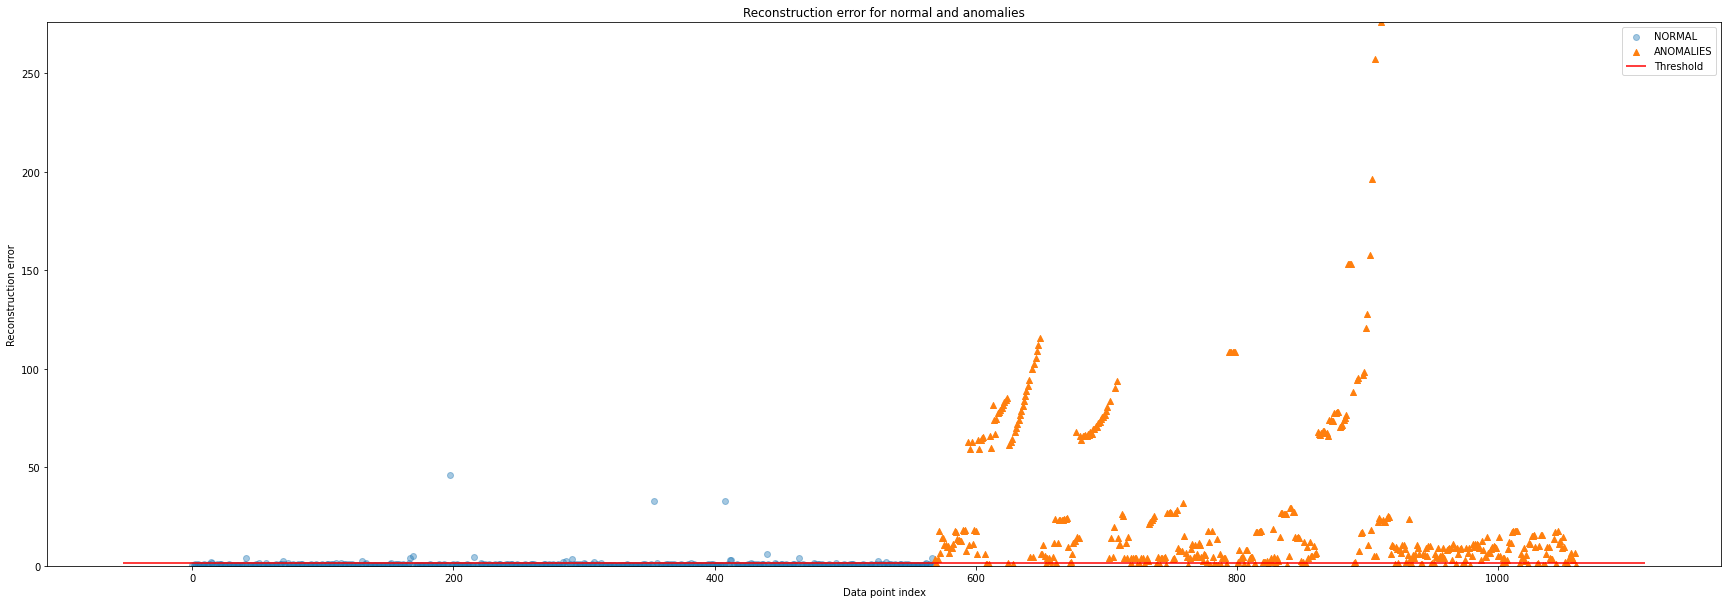

In [13]:
# PLOT THE RECONSTRUCTION LOSS FOR ENTIRE DATASET & THRESHOLD
# Anomalies are data points where the reconstruction loss is higher

threshold_fixed = 1.5
fig = plt.figure(figsize=(30,10))

ax = fig.add_subplot(111)

# NOTA: HAY QUE METER UNA TERCERA COLUMNA CON EL LABEL !!!!!
plot_data = np.column_stack((np.arange(len(reconstruction_loss_all)), reconstruction_loss_all))

#normal_data = plot_data[0:len(NORMAL_dataset)]
#anomalies_data = plot_data[len(NORMAL_dataset):len(NORMAL_dataset)+len(ANOMALIES_dataset)]

normal_data = plot_data[0:len(test_dataset)]
anomalies_data = plot_data[len(test_dataset):len(test_dataset)+len(ANOMALIES_dataset)]

ax.set_ylim([0, max(anomalies_data[:,1])])
#ax.set_ylim([0, 200])

ax.scatter(normal_data[:,0], normal_data[:,1], c='C0', alpha=0.4, marker='o', label='NORMAL')
ax.scatter(anomalies_data[:,0], anomalies_data[:,1], c='C1', marker='^', label='ANOMALIES')

#ax.plot(regular_data[:,0], regular_data[:,1], c='C0', alpha=0.4, marker='o', label='NORMAL')
#ax.plot(global_outliers[:,0], global_outliers[:,1], c='C1', marker='^', label='ANOMALIES')
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(loc='best')
plt.title("Reconstruction error for normal and anomalies")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

tensor([[547.,  22.],
        [ 62., 430.]])
Test Acc:  92.08294062205466 %


<ipython-input-14-9fa7f343e697>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + listclasses, rotation=90)
<ipython-input-14-9fa7f343e697>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + listclasses)


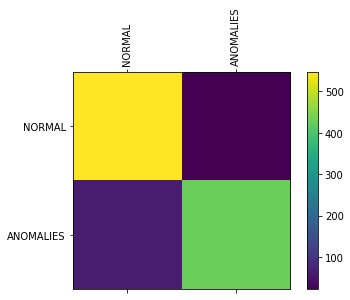

In [14]:
# CONFUSION MATRIX

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

listclasses = ['NORMAL', 'ANOMALIES']
numclasses = 2

TN = 0
FN = 0
TP = 0
FP = 0

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(numclasses, numclasses)

#normal_data = plot_data[0:len(test_dataset)]
#anomalies_data = plot_data[len(test_dataset):len(test_dataset)+len(ANOMALIES_dataset)]

for i in range(len(normal_data)):

    if (normal_data[i,1] < threshold_fixed):
        TN+=1
    else:
        FP+=1

#print (TN)
#print (FP)

for i in range(len(anomalies_data)):

    if (anomalies_data[i,1] > threshold_fixed):
        TP+=1
    else:
        FN+=1

#print (TP)
#print (FN)

confusion[0][0] = TN
confusion[0][1] = FP
confusion[1][0] = FN
confusion[1][1] = TP

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + listclasses, rotation=90)
ax.set_yticklabels([''] + listclasses)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

print (confusion)
print ('Test Acc: ', ((TN+TP)/(TN+FP+FN+TP))*100, '%')
